In [203]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)
 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [204]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

COLOR_PALETTE = [
    "#0070bc",
    "#05a298",
    "#d06b6d",
    "#a8e667",
    "#D3D3D3",
    "#57832e",
    "#56ebd3",
    "#0a4f4e",
    "#9ecbf4",
]

sns.set_theme(style="white")
plt.rcParams["figure.figsize"] = (12, 6)
sns.set_palette(COLOR_PALETTE)
pd.set_option("display.max_columns", None)


CAMBIOS_GLOSAS = {
    "Región Del Bíobío": "Región del Bío-Bío",
    "Región Metropolitana de Santiago": "Región Metropolitana de Santiago",
    "Región del Libertador General Bernardo O'Higgins": "Región del Libertador Bernardo O'Higgins",
    "Región De Antofagasta": "Región de Antofagasta",
    "Región De Los Lagos": "Región de Los Lagos",
    "Región Del Maule": "Región del Maule",
    "Región De Valparaíso": "Región de Valparaíso",
    "Región De Arica y Parinacota": "Región de Arica y Parinacota",
    "Región De Tarapacá": "Región de Tarapacá",
    "Región Aysén del General Carlos Ibáñez del Campo": "Región de Aysén del Gral.Ibañez del Campo",
    "Región De Coquimbo": "Región de Coquimbo",
    "Región De Magallanes y de La Antártica Chilena": "Región de Magallanes y Antártica Chilena",
    "Región De La Araucanía": "Región de La Araucanía",
    "Región De Atacama": "Región de Atacama",
    "Región De Ñuble": "Región de Ñuble",
    "Región De Los Ríos": "Región de Los Ríos",
}

DICT_SERVICIOS = {
    "COMUNAS_SIN_SS_EN_RM": [
        "ALHUE",
        "CURACAVI",
        "EL MONTE",
        "ISLA DE MAIPO",
        "MARIA PINTO",
        "PADRE HURTADO",
        "SAN PEDRO",
    ],
    "METROPOLITANO CENTRAL": [
        "CERRILLOS",
        "ESTACION CENTRAL",
        "MAIPU",
    ],  # , "SANTIAGO"], Se excluye santiago, para evitar asignarlo siempre que lo pongan para indicar la region
    "METROPOLITANO NORTE": [
        "COLINA",
        "CONCHALI",
        "HUECHURABA",
        "INDEPENDENCIA",
        "LAMPA",
        "QUILICURA",
        "RECOLETA",
        "TILTIL",
    ],
    "METROPOLITANO ORIENTE": [
        "ISLA DE PASCUA",
        "LA REINA",
        "LAS CONDES",
        "LO BARNECHEA",
        "MACUL",
        "NUNOA",
        "PENALOLEN",
        "PROVIDENCIA",
        "VITACURA",
    ],
    "METROPOLITANO OCCIDENTE": [
        "CERRO NAVIA",
        "LO PRADO",
        "MELIPILLA",
        "PENAFLOR",
        "PUDAHUEL",
        "QUINTA NORMAL",
        "RENCA",
        "TALAGANTE",
    ],
    "METROPOLITANO SUR": [
        "BUIN",
        "CALERA DE TANGO",
        "EL BOSQUE",
        "LA CISTERNA",
        "LO ESPEJO",
        "PAINE",
        "PEDRO AGUIRRE CERDA",
        "SAN BERNARDO",
        "SAN JOAQUIN",
        "SAN MIGUEL",
    ],
    "METROPOLITANO SURORIENTE": [
        "LA FLORIDA",
        "LA GRANJA",
        "LA PINTANA",
        "PIRQUE",
        "PUENTE ALTO",
        "SAN JOSE DE MAIPO",
        "SAN RAMON",
    ],
}

def buscar_glosa_comuna(texto):
    servicio_a_asingar = "NO VALIDO"
    for servicio, comunas_del_servicio in DICT_SERVICIOS.items():
        for comuna in comunas_del_servicio:
            if comuna in texto:
                return servicio

    if "SANTIAGO" in texto:
        return "METROPOLITANO CENTRAL"
    
    return "NO VALIDO"

In [205]:
df = pd.read_csv("../data/processed/df_procesada.csv")

In [206]:
# Eliminamos las filas que no tienen fecha de evaluación
df_limpia = df.dropna(subset="fecha_1_evaluacion").copy()
df_limpia = df_limpia.query("anio_1_evaluacion >= 2000 and anio_1_evaluacion <= 2022")

# Cambia glosas de la region
df_limpia["region"] = df_limpia["region"].str.replace(", Chile", "")
df_limpia["region"] = df_limpia["region"].replace(CAMBIOS_GLOSAS)

# Formatea fechas
df_limpia["fecha_1_evaluacion"] = pd.to_datetime(df_limpia["fecha_1_evaluacion"])
df_limpia["f_nac"] = pd.to_datetime(df_limpia["f_nac"])
df_limpia["edad_1_evaluacion_calc"] = (
    df_limpia["fecha_1_evaluacion"] - df_limpia["f_nac"]
).dt.days / 365

# Formatea previsiones
df_limpia["prevision"] = df_limpia["prevision"].str.upper()
df_limpia["prevision"] = df_limpia["prevision"].replace({"FONASA A": "A", "FNS A": "A"})

In [207]:
# Aisla solamente los registros de la region metropolitana
df_rm = df_limpia.query("region == 'Región Metropolitana de Santiago'").copy()
df_rm["direccion"] = df_rm["direccion"].fillna("")
df_rm["servicio_de_salud"] = df_rm["direccion"].apply(buscar_glosa_comuna)

In [208]:
# Obtiene la cantidad de pacientes anuales
cantidad_de_pacientes = df_limpia.groupby("anio_1_evaluacion")["rut"].nunique()
total_pacientes = df_limpia["rut"].nunique()

# Obtiene la distribucion de la prevision a lo largo de los anios
prevision = df_limpia.groupby(["prevision"])["rut"].nunique()
# prevision.loc["Total", :] =  prevision.sum()

# Obtiene la distribucion de la 1era edad de consulta
edad_primera_consulta = df_limpia.groupby("anio_1_evaluacion")["edad_1_evaluacion_calc"].describe()

# Obtiene el desglose por region
desglose_por_region = df_limpia.groupby("region")["rut"].nunique()

# Obtiene el desglose por servicio de salud RM
desglose_por_ss_rm = df_rm.groupby("servicio_de_salud")["rut"].nunique()

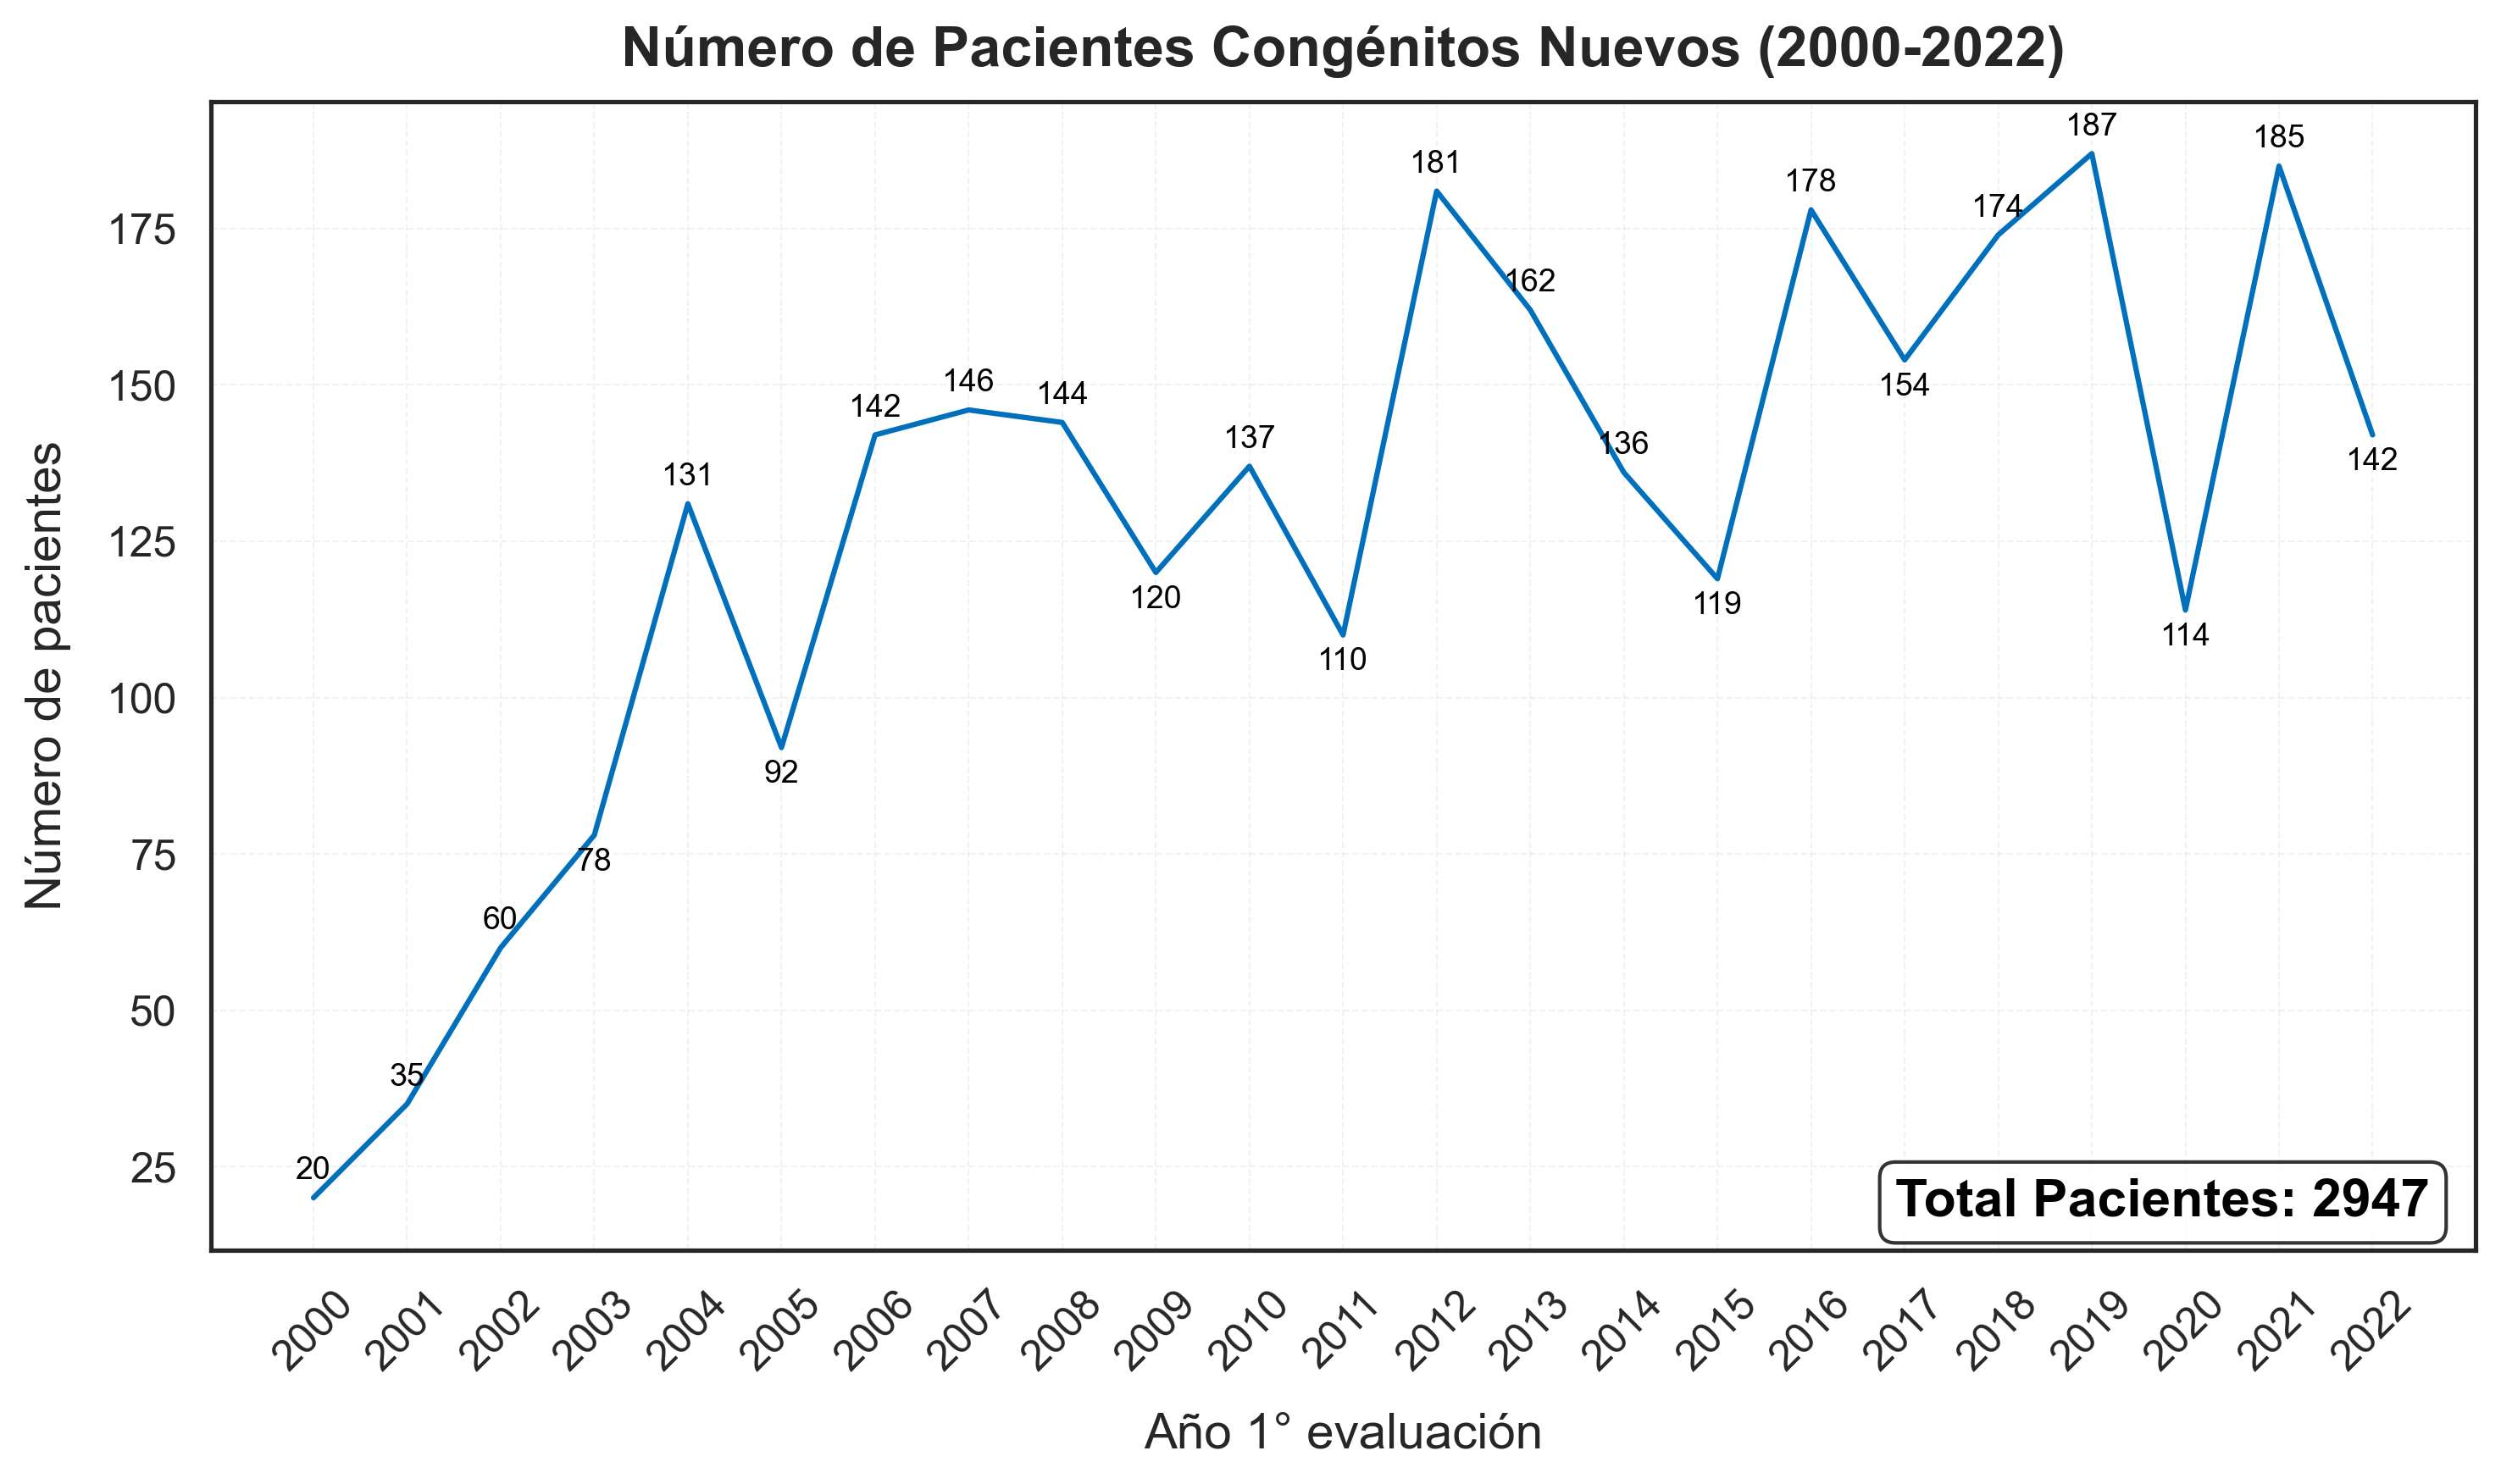

In [209]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot the data
cantidad_de_pacientes.plot(ax=ax)

# Set titles and labels
ax.set_title(
    "Número de Pacientes Congénitos Nuevos (2000-2022)", fontsize=16, weight="bold", pad=10
)
ax.set_xlabel("Año 1° evaluación", fontsize=14, labelpad=10)
ax.set_ylabel("Número de pacientes", fontsize=14, labelpad=10)

# Rotate x-axis labels for clarity
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Add labels above each point with boundary checks
ANIOS_POR_ABAJO = [2003, 2005, 2009, 2011, 2015, 2017, 2020, 2022]
ANIOS_POR_ARRIBA = [
    2000,
    2001,
    2002,
    2004,
    2006,
    2007,
    2008,
    2010,
    2012,
    2013,
    2014,
    2016,
    2018,
    2019,
    2021,
]

for anio in ANIOS_POR_ABAJO:
    value = cantidad_de_pacientes.loc[anio]
    ax.text(
        x=anio,
        y=value - 2,
        s=str(value),
        va="top",
        ha="center",  # Center-align horizontally
        fontsize=9,
        color="black",
    )

for anio in ANIOS_POR_ARRIBA:
    value = cantidad_de_pacientes.loc[anio]
    ax.text(
        x=anio,
        y=value + 2,
        s=str(value),
        va="bottom",
        ha="center",  # Center-align horizontally
        fontsize=9,
        color="black",
    )

# Add a text box in the lower right corner
text_box_content = f"Total Pacientes: {total_pacientes}"

ax.text(
    x=0.98,  # X-coordinate in figure-relative coordinates (1.0 is the far right)
    y=0.02,  # Y-coordinate in figure-relative coordinates (0.0 is the bottom)
    s=text_box_content,  # The text to display
    fontsize=15,
    color="black",
    weight="bold",
    ha="right",  # Align text to the right
    va="bottom",  # Align text to the bottom
    bbox=dict(
        boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8
    ),  # Add a border and background
    transform=ax.transAxes,  # Use axis-relative coordinates
)

# Adjust x-axis tick frequency
ax.set_xticks(cantidad_de_pacientes.index)  # Show all years (or adjust as needed)

# Add a grid for better readability
ax.grid(visible=True, which="major", linestyle="--", linewidth=0.5, color="gray", alpha=0.1)

# Adjust layout for better spacing
fig.tight_layout()

# Save the figure
plt.savefig("../reports/figures/numero_de_pacientes.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

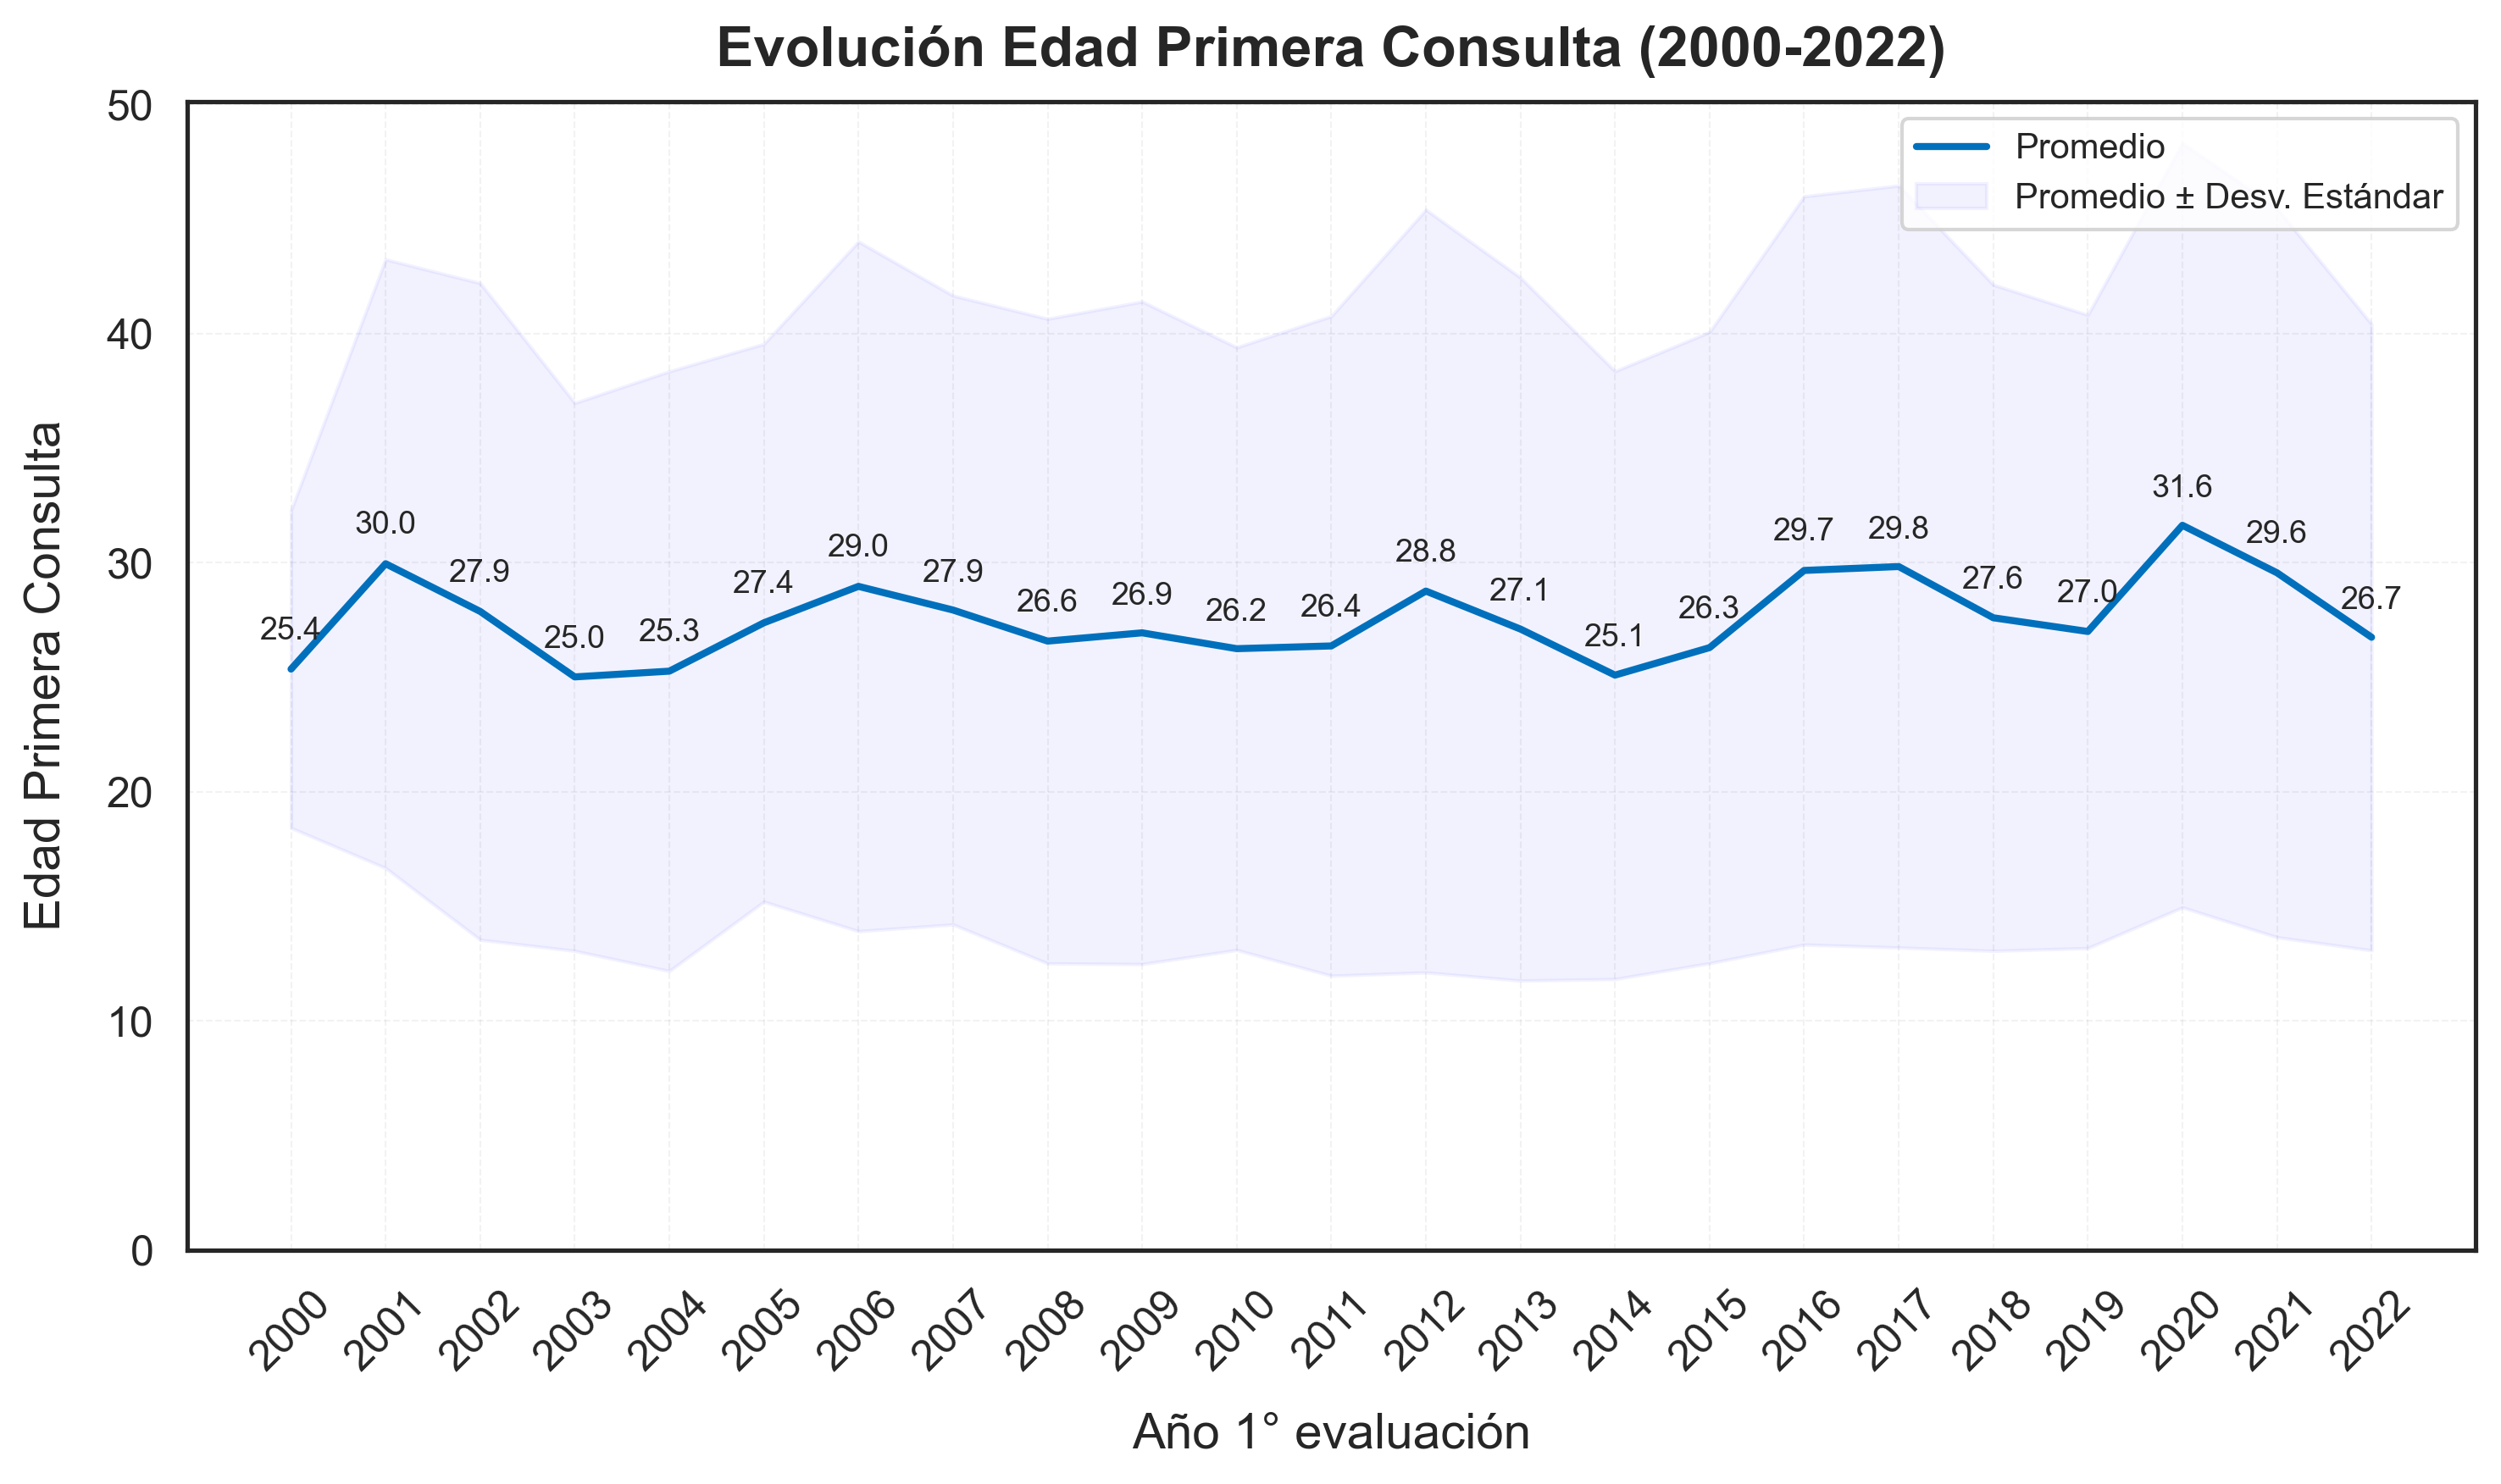

In [210]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot the mean as a line
ax.plot(
    edad_primera_consulta.index, 
    edad_primera_consulta["mean"], 
    label="Promedio", 
    color="#0070bc", 
    linewidth=2
)

# # Add shaded areas for min and max
# ax.fill_between(
#     edad_primera_consulta.index, 
#     edad_primera_consulta["min"], 
#     edad_primera_consulta["max"], 
#     color="blue", 
#     alpha=0.1, 
#     label="Min-Max Range"
# )

# Optionally, add shaded areas for mean ± std
if "std" in edad_primera_consulta.columns:
    ax.fill_between(
        edad_primera_consulta.index,
        edad_primera_consulta["mean"] - edad_primera_consulta["std"],
        edad_primera_consulta["mean"] + edad_primera_consulta["std"],
        color="blue",
        alpha=0.05,
        label="Promedio ± Desv. Estándar"
    )

# Customize plot
ax.set_title(
    "Evolución Edad Primera Consulta (2000-2022)", fontsize=16, weight="bold", pad=10
)
ax.set_xlabel("Año 1° evaluación", fontsize=14, labelpad=10)
ax.set_ylabel("Edad Primera Consulta", fontsize=14, labelpad=10)

# Rotate x-axis labels for clarity
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.ylim(bottom=0)

# Agrega valores sobre linea
for anio, valor in edad_primera_consulta["mean"].items():
    valor = round(valor, 1)
    ax.text(x=anio, y=valor + 1, s=str(valor), va="bottom", ha="center", fontsize=9)

# Add a grid for better readability
ax.grid(visible=True, which="major", linestyle="--", linewidth=0.5, color="gray", alpha=0.1)

# Add a legend
ax.legend(fontsize=10)

# Adjust x-axis tick frequency
ax.set_xticks(edad_primera_consulta.index)  # Show all years (or adjust as needed)

fig.tight_layout()

# Save the figure
plt.savefig("../reports/figures/edad_primera_consulta.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()


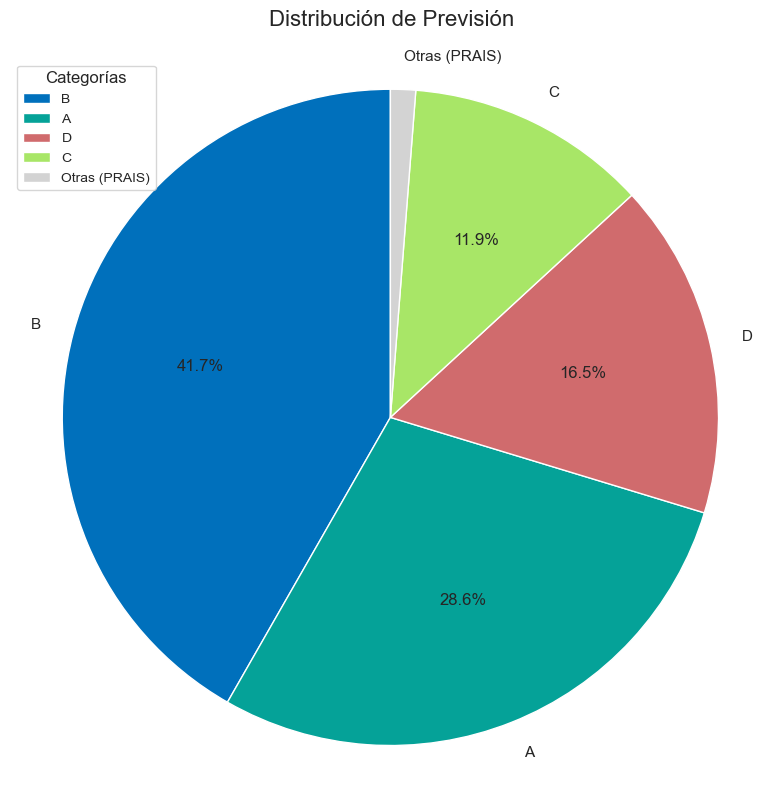

In [211]:
# Set a threshold for categorizing "low-frequency" categories
threshold = (
    prevision.sum() * 0.05
)  # e.g., categories with less than 5% of total sum will be grouped

# Group categories with low frequencies into "Otras (PRAIS)"
prevision_grouped = prevision[prevision >= threshold]
prevision_grouped["Otras (PRAIS)"] = prevision[prevision < threshold].sum()
prevision_grouped = prevision_grouped.sort_values(ascending=False)


# Define a function to hide percentage for "Otras (PRAIS)"
def no_other_pct(pct, allvals):
    absolute = round(pct / 100.0 * sum(allvals), 0)  # Calculate the absolute value from percentage
    if absolute == prevision_grouped["Otras (PRAIS)"]:
        return ""  # Hide percentage for "Otras (PRAIS)" category
    else:
        return f"{pct:.1f}%"  # Format the percentage for other categories


# Create a prettier pie plot
fig, ax = plt.subplots(figsize=(8, 8))  # Larger figure for better clarity
prevision_grouped.plot(
    kind="pie",
    ax=ax,
    autopct=lambda pct: no_other_pct(pct, prevision_grouped),  # Use custom function for percentage
    startangle=90,
    labels=prevision_grouped.index,
    # pctdistance=1.2,  # Move percentage labels outside the pie (optional)
    # labeldistance=1.4,  # Move category labels outside the pie (optional)
)

# Set title and adjust layout
fig.suptitle("Distribución de Previsión", fontsize=16)  # Adjust 'y' to move title upwards
ax.set_ylabel("")  # Remove y-axis label for better clarity

# Add a legend with specific settings
ax.legend(title="Categorías", loc="upper left", fontsize=10)

# Make sure the pie is displayed as a circle
ax.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.tight_layout()

# Save the plot as a PNG file with 300 DPI
plt.savefig("../reports/figures/distribucion_prevision.png", dpi=300)

plt.show()

## Mapas

In [212]:
regiones_df = gpd.read_file(
    "../data/raw/mapas/regional/Regional.shp", engine="pyogrio", use_arrow=True
)
servicios_df = gpd.read_file(
    "../data/raw/mapas/Territorios de los Servicios de Salud/2_SERVICIOS_SALUD.shp",
    engine="pyogrio",
    use_arrow=True,
)

In [269]:
# Join the data
resumen_regiones = regiones_df.set_index("Region").join(desglose_por_region)


resumen_servicios = servicios_df.set_index("NOM_SS").join(desglose_por_ss_rm).dropna()
resumen_servicios["coords"] = resumen_servicios["geometry"].apply(
    lambda x: x.representative_point().coords[:]
)
resumen_servicios["coords"] = [coords[0] for coords in resumen_servicios["coords"]]

In [292]:
resumen_regiones["rut"]

Region
Región de Arica y Parinacota                   57.0
Región de Tarapacá                             44.0
Región de Antofagasta                          61.0
Región de Magallanes y Antártica Chilena       30.0
Región de Aysén del Gral.Ibañez del Campo      37.0
Región de Atacama                              36.0
Región de Coquimbo                            214.0
Región de Valparaíso                          156.0
Región Metropolitana de Santiago             1422.0
Región de Los Lagos                           149.0
Región de Los Ríos                             18.0
Región de La Araucanía                         82.0
Región del Bío-Bío                            221.0
Región de Ñuble                                 6.0
Región del Maule                              223.0
Región del Libertador Bernardo O'Higgins      175.0
Zona sin demarcar                               NaN
Name: rut, dtype: float64

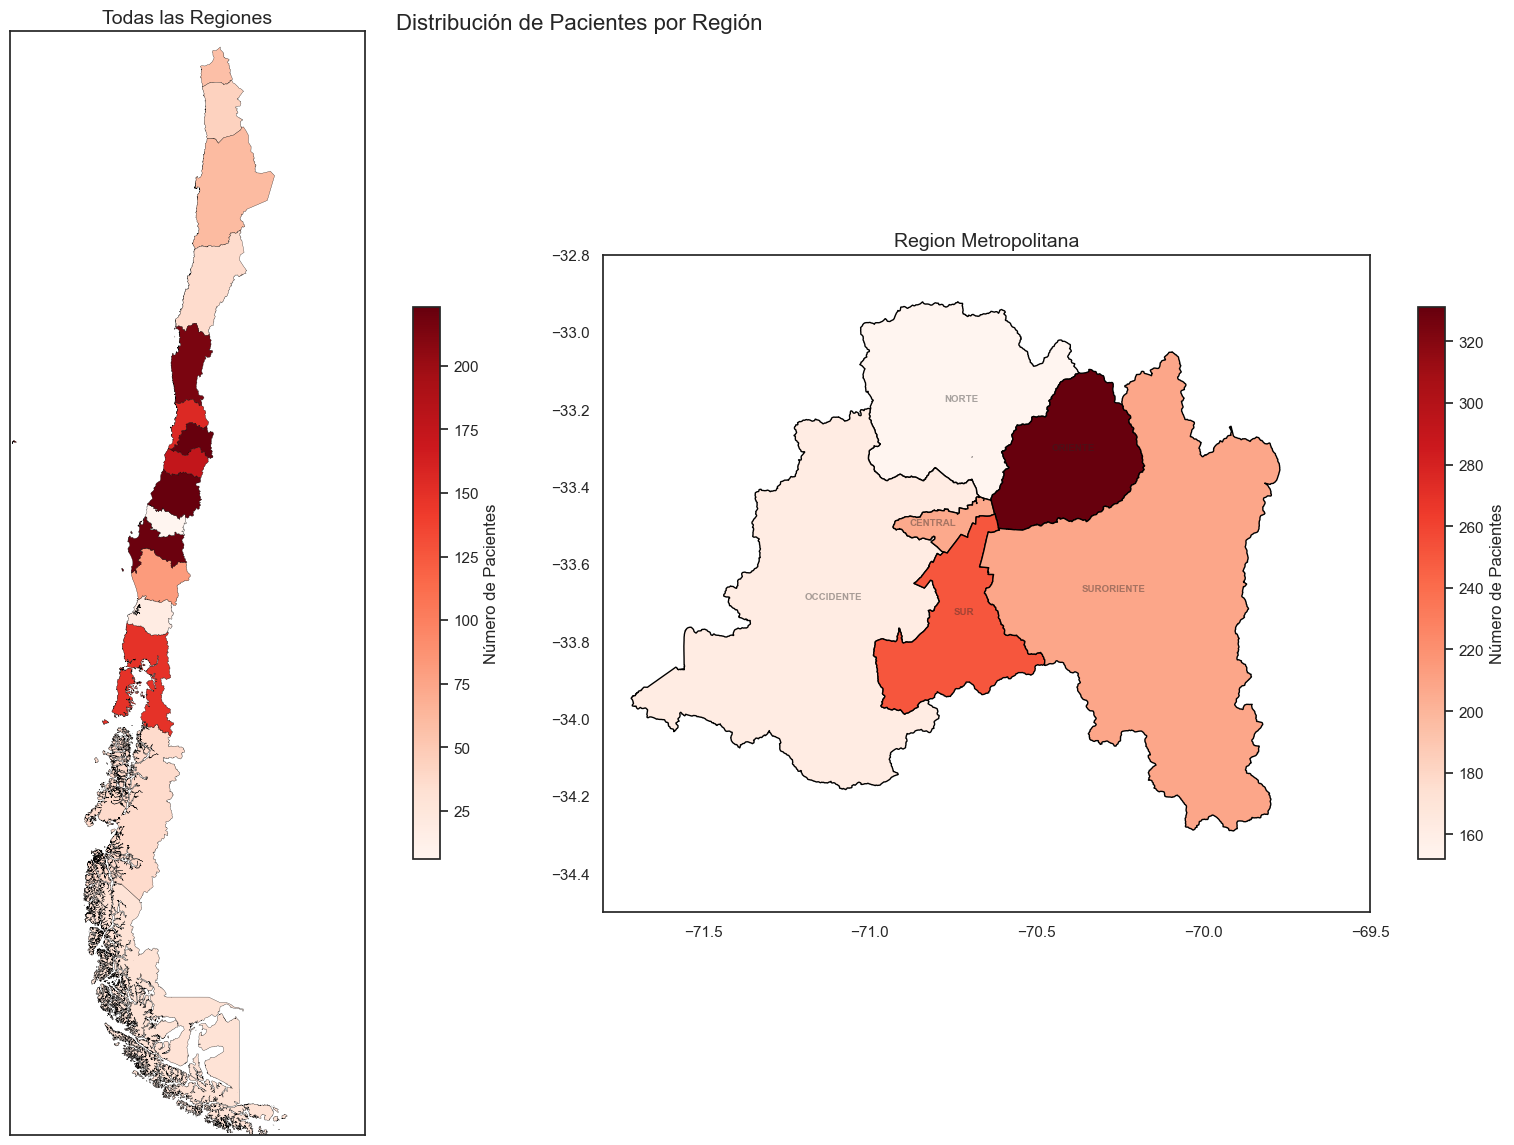

In [294]:
# Set the figure size and aspect ratio
fig, ax = plt.subplots(1, 2, figsize=(20, 12))  # Wider layout for better separation of subplots

# Plot the filtered entire GeoDataFrame on the second subplot
resumen_regiones.plot(
    column="rut",
    cmap="Reds",
    ax=ax[0],
    legend=True,
    legend_kwds={
        "shrink": 0.5,  # Match the size of the colorbar with the first subplot
        "label": "Número de Pacientes",
        "orientation": "vertical",
    },
    vmax=223,
    linewidth=0.2,
    edgecolor="black",
)

resumen_servicios.plot(
    column="rut",
    cmap="Reds",
    ax=ax[1],
    legend=True,
    legend_kwds={
        "shrink": 0.5,  # Match the size of the colorbar with the first subplot
        "label": "Número de Pacientes",
        "orientation": "vertical",
    },
    linewidth=1,
    edgecolor="black"
)

for idx, row in resumen_servicios.iterrows():
    nombre_a_imputar = row.name.replace("METROPOLITANO ", "")
    ax[1].text(
        s=nombre_a_imputar,
        x=row["coords"][0],
        y=row["coords"][1],
        ha="center",
        fontsize=7,
        alpha=0.4,
        weight="bold"
    )

# Set titles for each subplot
ax[0].set_title("Todas las Regiones", fontsize=14)
ax[1].set_title("Region Metropolitana", fontsize=14)

# Ajusta el mapa a mostrar
ax[0].axis([-8.8e6, -7e6, -7.5e6, -1.9e6])
ax[1].axis([-71.8, -69.5, -34.5, -32.8])

# Saca las marcas de latitud y longitud
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

# ax[1].get_xaxis().set_visible(False)
# ax[1].get_yaxis().set_visible(False)

# Overall plot title
fig.suptitle("Distribución de Pacientes por Región", fontsize=16, y=0.95)

# Adjust spacing between plots and tighten layout
plt.tight_layout()

# Show the plot
plt.show()